In [59]:
import psycopg2, multiprocessing, psycopg2.extras, os, json, sys, time, scipy, datetime
from multiprocessing import Pool, Manager 
from collections import Counter
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import shape, mapping
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Temporal Clustering

In [164]:
input_directory  = "/data/chime/geo2/PROCESSED/NJ/NorthernInterior_Stage1/"
output_directory = "/data/chime/geo2/PROCESSED/NJ/NorthernInterior_Stage2/"

#SANDY
_landfall_str = '201210300000' # Remember, this is UTC
_start_str    = '201210290000' # (ie when was the evacuation ordered (8pm the 28th)
_end_str      = '201210310000'
_landfall = pd.Timestamp(_landfall_str)
_start    = pd.Timestamp(_start_str)
_end      = pd.Timestamp(_end_str)

#MATTHEW
# _landfall_str = '201610060000' #Using these dates for Matthew...
# _start_str    = '201610040000' # (ie when was the evacuation?)
# _end_str      = '201610080000'
# _landfall = pd.Timestamp(_landfall_str)
# _start    = pd.Timestamp(_start_str)
# _end      = pd.Timestamp(_end_str)

## 0. Load all the geo-clustered tweets

In [165]:
users_in = sorted(os.listdir(input_directory))
print("Found {0} users in {1}".format(len(users_in), input_directory))

Found 985 users in /data/chime/geo2/PROCESSED/NJ/NorthernInterior_Stage1/


## Sampling?!

<hr>

In [166]:
def loader_function(args):
    uFile, path, q = args
    u = json.load(open(path+"/"+uFile,'r'))
    tweets = []
    for t in u['features']:
        if t['geometry']:
            t['properties']['geometry'] = shape(t['geometry'])
        t['properties']['date'] = pd.Timestamp(t['properties']['date'])
        tweets.append(t['properties'])
    q.put(1)
    return gpd.GeoDataFrame(tweets)

In [167]:
#Parallel runtime
p = Pool(30)
m = Manager()
q = m.Queue()

args = [(i, input_directory, q) for i in users_in]
result = p.map_async(loader_function, args)

# monitor loop
while True:
    if result.ready():
        break
    else:
        size = q.qsize()
        sys.stderr.write("\rProcessed: {0}, {1:.3g}%".format(size, size/len(args)*100))
        time.sleep(0.5)
sys.stderr.write("\rProcessed: {0}, {1:.3g}%".format(q.qsize(), q.qsize()/len(args)*100))
users = result.get()
p.close()

Processed: 985, 100%

In [168]:
print("{0} total tweets for all users".format(sum([len(x) for x in users])))

171651 total tweets for all users


In [169]:
user_names_in = [x[:-8] for x in users_in]
user_names_in[:5]

['27hotohori', '3131yb', '5h0rtie', '92hughes92', '977wctyjesse']

## Identifying Temporal Clusters
Use a custom _worker_ function to find specific time clusters

### Enough Tweets?

Ensure that we have the following for each user:
1. Geo-Cluter Information (If no geo-clusters are available, remove)
2. Enough Tweets (At least *A* Tweet during the storm)

In [170]:
def time_cluster(t):
    '''Given a time, returns the cluster (1 of 12)'''
    t = t.tz_convert("EST")
    hour = t.hour//4 + 1
    if t.weekday()>4:
        return 6+hour
    else:
        return hour
    
def worker_function(args):
    userDF, q = args
    
    #If no tweets around the time of the storm, then fail. 
    #TODO: Move this up in the processing chain to improve performance
    if len(userDF.query("date > %s & date < %s"%(_start_str, _end_str))) < 1:
        q.put(1)
        return None
    
    userDF['day_cluster'] = userDF.date.apply(lambda t: time_cluster(t))
    q.put(0)
    return userDF

In [171]:
#Parallel runtime
p = Pool(30)
m = Manager()
q = m.Queue()

args = [(i, q) for i in users]
result = p.map_async(worker_function, args)

# monitor loop
while True:
    if result.ready():
        break
    else:
        size = q.qsize()
        sys.stderr.write("\rProcessed: {0}, {1:.3g}%".format(size, size/len(args)*100))
        time.sleep(0.5)
sys.stderr.write("\rProcessed: {0}, {1:.3g}%".format(q.qsize(), q.qsize()/len(args)*100))

values = result.get()
x = [i for i in values  if i is not None]
nones = [i for i in values  if i is None]
p.close()

Processed: 985, 100%

In [172]:
print("Successfully processed {0} users\n{1} Users failed".format(len(x),len(nones)))
users_past_first_step = [x.user[0].lower() for x in values if x is not None]
print("First 5 users past the first step", users_past_first_step[:5])

Successfully processed 329 users
656 Users failed
First 5 users past the first step ['___mariahleigh', '_aggression_', 'adaytosurvive', 'adeblas17', 'aguiarsean']


In [173]:
#Failed:
failed_users = set(user_names_in) - set(users_past_first_step)
print("Failed user set size: ", len(failed_users))

Failed user set size:  656


In [174]:
_users = sorted(x, key=lambda y: len(y), reverse=True) # Put the verbose users up front

## 2. Group the clusters and find which geo-clusters correspond with home hours

In [175]:
def rank_clusters(df):
    """
    There is definitely room for the logic in _this_ function to improve, but for now it looks good :) 
    """
    gb_geo = df.query('date < '+_start_str).groupby('cluster')
    if len(gb_geo) < 1:
        return (None,None)
    _agged = gb_geo['day_cluster'].agg({"tweets":pd.Series.count,
                                        "Number Unique Times":pd.Series.nunique,
                                        "day_cluster_counts": lambda t: Counter(t),
                                        "HomeTimes": lambda t: any(t==1) or any(t==2) or any(t==6),
                                      }).sort_values('Number Unique Times', ascending=False).query('cluster>0')
    hc = None
    
    #If there is a cluster with hometimes, then return that (highest rated based on unique times)
    if len(_agged.query('HomeTimes'))>0:
        hc = _agged.query('HomeTimes').iloc[0].name
        
    return hc, _agged

In [176]:
vals= []
len_users = len(_users)
user_collection = []

user_meta_collection = []
for idx, U in enumerate(_users):
    
    hc = rank_clusters(U)[0]
    if hc is None:
        hc_coords = None
    else:
        hc_coords = U.query("cluster=={0}".format(hc))['cluster_center'].values[0]
        
    user_meta_collection.append({
            'user':U['user'].values[0],
            'uid' :U['uid'].values[0],
            'tweets':len(U),
            'home_cluster': hc,
            'home_cluster_coords':hc_coords
        })

    U['home_cluster_id'] = pd.Series(hc)
    
    sys.stderr.write("\r{0} of {1}".format(idx+1, len_users))
_user_meta = pd.DataFrame(user_meta_collection)
sys.stderr.write("\n\nClustered: {0}, Failed: {1}".format( len(_user_meta[~np.isnan(_user_meta.home_cluster)]),
                                                           len(_user_meta[ np.isnan(_user_meta.home_cluster)])))

329 of 329

Clustered: 266, Failed: 63

In [177]:
users_with_homes = [u for u in _users if u.home_cluster_id.count()>0]

Identify which users do not make it past?

In [178]:
users_past_second_step = [x.user[0].lower() for x in users_with_homes]

In [179]:
pitched_users = set(users_past_first_step) - set(users_past_second_step)
print("This many users from first step did not make it past the second step: ", len(pitched_users))

This many users from first step did not make it past the second step:  63


### Export these results

In [180]:
if not os.path.exists(output_directory):
    os.mkdir(output_directory)

In [181]:
#Export the User Meta Dataframe first
with open(output_directory+'/'+'temporal_clustered_user_meta.json','w') as metaOut:
    metaOut.write(_user_meta.to_json())

In [182]:
_user_meta.head()

,home_cluster,home_cluster_coords,tweets,uid,user
0,1.0,"{""type"": ""Point"", ""coordinates"": [-73.69247457...",14231,75153082,Andrewthemark
1,1.0,"{""type"": ""Point"", ""coordinates"": [-74.17544402...",3115,250117107,AmandaaTar
2,1.0,"{""type"": ""Point"", ""coordinates"": [-74.20528803...",2055,336126439,FreddyJ_23
3,1.0,"{""type"": ""Point"", ""coordinates"": [-74.12807287...",1959,158138985,Ian_Kanterman
4,1.0,"{""type"": ""Point"", ""coordinates"": [-74.24760644...",1842,453608617,BethElsasser


## 3.  Write these users to disk

In [183]:
def safe_mapping(p):
    if p==None or np.isnan(p).any():
        return None
    else:
        return mapping(p)

In [184]:
def safe_json_export(args):
    df, path, q = args
    df = df.copy()
    uName = df.head(1).user.values[0].lower()
    df['date'] = df['date'].apply(lambda t: datetime.datetime.strftime(t,'%Y-%m-%dT%H:%M:%SZ'))

    #Write the metadata:
    with open('/data/www/chime/movement-derivation/user-metadata/'+uName+".geojson",'w') as userMeta:
        userMeta.write(df.query("cluster=={0}".format(df.iloc[0].home_cluster_id)).cluster_center.values[0])

    clean = df.where((pd.notnull(df)), None)
    geojson = {"type":"FeatureCollection","features":[]}
    for _, row in clean.iterrows():
        geom = safe_mapping(row.geometry)
        feature = {'type':'Feature',
                   'geometry':geom,
                   'properties':row.to_dict()
                    }
        del feature['properties']['geometry']
        geojson['features'].append(feature)
    
    with open(path+"/"+uName+'.geojson','w') as oFile:
        json.dump(geojson, oFile) 

    if q is not None:
        q.put(1)

In [185]:
#Parallel runtime
p = Pool(30)
m = Manager()
q = m.Queue()

args = [(i, output_directory, q) for i in users_with_homes]
result = p.map_async(safe_json_export, args)

sys.stderr.write("Exporting {0} users to {1}\n".format(len(args),output_directory))

# monitor loop
while True:
    if result.ready():
        break
    else:
        size = q.qsize()
        sys.stderr.write("\rProcessed: {0}, {1:.3g}%".format(size, size/len(args)*100))
        time.sleep(0.5)
p.close()
sys.stderr.write("\rProcessed: {0}, {1:.3g}%".format(q.qsize(), q.qsize()/len(args)*100))

Exporting 266 users to /data/chime/geo2/PROCESSED/NJ/NorthernInterior_Stage2/
Processed: 266, 100%

<hr>
<hr>
# End of Processing 

<hr><hr>
# Beginning of Visual Inspection

In [186]:
x = users_with_homes[0]

In [187]:
x.cluster.count()

14231

In [188]:
cluster_dist = pd.Series(sorted([u.cluster.nunique() for u in _users]))

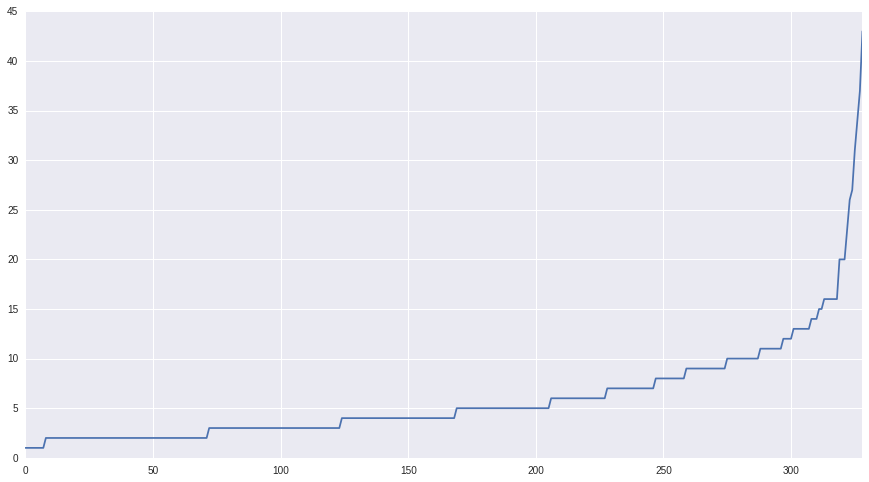

In [189]:
cluster_dist.plot(figsize=(15,8))

In [190]:
x.head()

,cluster,cluster_center,coords,date,geo_delta,geometry,speed,text,time_delta,tweet_id,uid,user,day_cluster,home_cluster_id
0,1,"{""type"": ""Point"", ""coordinates"": [-73.69247457...","[-73.69149255, 40.67361288]",2012-09-04 00:21:21+00:00,NaN,POINT (-73.69149255000001 40.67361288),NaN,Why cant cole be joined?,NaN,242779345796608000,75153082,Andrewthemark,5,1.0
1,1,"{""type"": ""Point"", ""coordinates"": [-73.69247457...","[-73.69149255, 40.67361288]",2012-09-04 00:22:43+00:00,0.00000,POINT (-73.69149255000001 40.67361288),0.000000,Um... Wut.,82.0,242779689851162624,75153082,Andrewthemark,5,NaN
2,1,"{""type"": ""Point"", ""coordinates"": [-73.69247457...","[-73.69149255, 40.67361288]",2012-09-04 00:22:57+00:00,0.00000,POINT (-73.69149255000001 40.67361288),0.000000,THEYRE CHANTING LETS GO SHEAMUS!,14.0,242779747329904640,75153082,Andrewthemark,5,NaN
3,1,"{""type"": ""Point"", ""coordinates"": [-73.69247457...","[-73.69149255, 40.67361288]",2012-09-04 00:24:06+00:00,0.00000,POINT (-73.69149255000001 40.67361288),0.000000,Why are there only 3 commentators in vince's m...,69.0,242780037139558400,75153082,Andrewthemark,5,NaN
4,1,"{""type"": ""Point"", ""coordinates"": [-73.69247457...","[-73.69153706, 40.67357022]",2012-09-04 00:27:03+00:00,6.04912,POINT (-73.69153706 40.67357022),0.034176,Why would they take out lawler and mathews?,177.0,242780778960912387,75153082,Andrewthemark,5,NaN
